In [1]:
from StackGP import *
import sympy as sym
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv('/Users/nathanhaut/Downloads/pmlb/datasets/195_auto_price/195_auto_price.csv')

In [10]:
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

In [3]:
def ComputeSymbolicHess(model,vars):
    printedModel=sym.simplify(printGPModel(model))
    if type(printedModel)==float:
        return sym.matrices.dense.MutableDenseMatrix(np.zeros((vars,vars)))
    hess=sym.hessian(printedModel, [symbols('x'+str(i)) for i in range(vars)])
    return hess

def EvaluateHess(hess,vars,values):
    numHess=hess.subs({symbols('x'+str(j)):values[j] for j in range(vars)})
    hessN = np.array(numHess).astype(float)
    rankN=np.linalg.matrix_rank(hessN,tol=0.0001*0.0001*10)
    return rankN

def Approx2Deriv(model,values,diff1,diff2,positions): #maybe diff should be relative to the variation of each feature
    term1=[values[i]+diff1 if i == positions[0] else values[i] for i in range(len(values))]
    term1=[term1[i]+diff2 if i == positions[1] else term1[i] for i in range(len(term1))]
    term2=[values[i]-diff1 if i == positions[0] else values[i] for i in range(len(values))]
    term2=[term2[i]+diff2 if i == positions[1] else term2[i] for i in range(len(term2))]
    term3=[values[i]+diff1 if i == positions[0] else values[i] for i in range(len(values))]
    term3=[term3[i]-diff2 if i == positions[1] else term3[i] for i in range(len(term3))]
    term4=[values[i]-diff1 if i == positions[0] else values[i] for i in range(len(values))]
    term4=[term4[i]-diff2 if i == positions[1] else term4[i] for i in range(len(term4))]
    return ((evaluateGPModel(model,term1)-evaluateGPModel(model,term2))/((2*diff1))
            -(evaluateGPModel(model,term3)-evaluateGPModel(model,term4))/((2*diff1)))/(2*diff2)

def ApproxHessRank(model,vars,values,diff1=0.001,diff2=0.001):
    hess=[[Approx2Deriv(model,values,diff1,diff2,[i,j]) for i in range(vars)] for j in range(vars)]
    hessN = np.array(hess).astype(float)
    rankN=np.linalg.matrix_rank(hessN,tol=0.0001*0.0001*10)
    return rankN

In [6]:
def runExperiment(file,targetID,IDrange,name):
    #Import data file
    data=pd.read_csv(file)#"/Users/nathanhaut/Downloads/pmlb/datasets/195_auto_price/195_auto_price.csv")
    
    #Extract data from file
    #vars=data.columns


    #Split train and test data
    trainSize=np.floor(len(data)*0.7)
    testSize=len(data)-trainSize

    trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
    testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

    trainData=data.iloc[trainIndices]
    testData=data.iloc[testIndices]

    #Extract input and response data
    trainInput=np.array(trainData.T)[:-1]
    trainResponse=np.array(trainData.T)[-1]
    testInput=np.array(testData.T)[:-1]
    testResponse=np.array(testData.T)[-1]


    #Get position of max, min, and mean values of response
    maxPos=np.argmax(trainResponse)
    minPos=np.argmin(trainResponse)
    diff=np.abs(trainResponse-np.mean(trainResponse))
    meanPos=np.argmin(diff)
    

    #Create target basis set function
    func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
    #Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
    ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10)
    temp=[mods for mods in ID3Omodels if mods[2][2]<1]
    if len(temp)>0:
        ID3Omodels=temp
    print("ID3O models done", ID3Omodels[0][2])
    IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10)
    temp=[mods for mods in IDmodels if mods[2][1]<1]
    if len(temp)>0:
        IDmodels=temp
    print("ID models done", IDmodels[0][2])

    compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300)
    print("Complexity models done")
    tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=100,align=False,elitismRate=10,popSize=300)
    print("Tourney models done")

    #Select target models from approaches
    IDmodel=IDmodels[0]
    ID3Omodel=ID3Omodels[0]
    compModel=compModels[0]
    tourneyModel=tourneyModels[0]

    #Train Stats
    IDStats=IDmodels[0][2]
    ID3OStats=ID3Omodels[0][2]
    compStats=compModels[0][2]
    tourneyStats=tourneyModels[0][2]

    #Align models
    IDmodel=alignGPModel(IDmodel,trainInput,trainResponse)
    ID3Omodel=alignGPModel(ID3Omodel,trainInput,trainResponse)
    compModel=alignGPModel(compModel,trainInput,trainResponse)
    tourneyModel=alignGPModel(tourneyModel,trainInput,trainResponse)

    #Evaluate models on test data
    IDfitness=fitness(IDmodel,testInput,testResponse)
    ID3Ofitness=fitness(ID3Omodel,testInput,testResponse)
    compFitness=fitness(compModel,testInput,testResponse)
    tourneyFitness=fitness(tourneyModel,testInput,testResponse)

    IDRMSE=np.linalg.norm(evaluateGPModel(IDmodel,testInput)-testResponse)
    ID3ORMSE=np.linalg.norm(evaluateGPModel(ID3Omodel,testInput)-testResponse)
    compRMSE=np.linalg.norm(evaluateGPModel(compModel,testInput)-testResponse)
    tourneyRMSE=np.linalg.norm(evaluateGPModel(tourneyModel,testInput)-testResponse)

    #Save results
    results=pd.DataFrame({'ID':[IDStats, printGPModel(IDmodel),IDfitness,IDRMSE],'ID3O':[ID3OStats, printGPModel(ID3Omodel),ID3Ofitness,ID3ORMSE],'Complexity':[compStats, printGPModel(compModel),compFitness,compRMSE],'Tourney':[tourneyStats, printGPModel(tourneyModel),tourneyFitness,tourneyRMSE]})
    results.to_csv('Results/'+name+'.csv')


    #Return target models and fitnesses on test data
    return results


In [42]:
runExperiment('/Users/nathanhaut/Downloads/pmlb/datasets/195_auto_price/195_auto_price.csv',2,1,'autoPrice0')

ID3O models done [0.14028133070434312, 8, 0.0]
ID models done [0.1875845602008236, 0]
Complexity models done
Tourney models done


,ID,ID3O,Complexity,Tourney
0,"[0.1875845602008236, 0]","[0.14028133070434312, 8, 0.0]","[0.1370243973816997, 14]",[0.1300292250173012]
1,0.13948374369652*x4*x6 + 0.13948374369652*x7 -...,3310.37648714324 + 3.5218e-10*x4**4*x6**2/sqrt...,-1.6e-12*x4**4*x6**2*(x13 - x4 + sqrt(x8)*x9) ...,2.93128e-9*x6*(x4**4*sqrt(1/(sqrt(x9*sqrt(exp(...
2,0.149617,0.11134,0.102169,0.118915
3,18307.617616,16086.329562,15383.466563,16408.200383


In [31]:
np.argmin(15)

0

In [3]:
def runTrials(file, target,dev,name,count):
    #Create variables to store output

    #Loop through trials
    for i in range(count):
        #Run experiments
        results=runExperiment(file,target,dev,name+str(i))


def loadData():
    #Load statistics from results file
    pass



In [4]:
runTrials('/Users/nathanhaut/Downloads/pmlb/datasets/195_auto_price/195_auto_price.csv',2,1,'autoPrice',10)

ID3O models done [0.19796621817701765, 12, 0.0]
ID models done [0.2042933907052018, 0.0]
Complexity models done
Tourney models done
ID3O models done [0.12426930944762449, 11, 0.0]
ID models done [0.15888126196718777, 0.0]
Complexity models done
Tourney models done
ID3O models done [0.13603174904530935, 8, 0.0]
ID models done [0.14857585922348615, 0.0]
Complexity models done
Tourney models done
ID3O models done [0.09796144907216553, 10, 0.6666666666666667]
ID models done [0.18885923458682696, 0.6666666666666667]
Complexity models done
Tourney models done
ID3O models done [0.13399808200498708, 12, 0.33333333333333326]
ID models done [0.16781874006443598, 0]
Complexity models done
Tourney models done
ID3O models done [0.11302109436238283, 13, 0.0]
ID models done [0.16729028628700626, 0.33333333333333326]
Complexity models done
Tourney models done
ID3O models done [0.1710346077962165, 11, 0.0]
ID models done [0.21016395673725852, 0]
Complexity models done
Tourney models done
ID3O models do

In [7]:
runTrials('/Users/nathanhaut/Downloads/pmlb/datasets/581_fri_c3_500_25/581_fri_c3_500_25.csv',16,5,'581_fri',10)

ID3O models done [0.34491005735286684, 12, 8.0]
ID models done [0.6356565675797917, 8.0]
Complexity models done
Tourney models done
ID3O models done [0.5215941860924147, 10, 9.0]
ID models done [0.3361041257202273, 8.0]
Complexity models done
Tourney models done
ID3O models done [0.6244243029696642, 11, 10.0]
ID models done [0.9756137571175885, 0]
Complexity models done
Tourney models done
ID3O models done [0.4211934006072535, 22, 9.333333333333334]
ID models done [0.24165927087812722, 5.0]
Complexity models done
Tourney models done
ID3O models done [0.6056314853390397, 15, 9.333333333333334]
ID models done [0.4960041886123969, 10.666666666666666]
Complexity models done
Tourney models done
ID3O models done [0.731755245797431, 8, 9.0]
ID models done [0.27786796775519196, 5.333333333333334]
Complexity models done
Tourney models done
ID3O models done [0.6786104518353819, 5, 11.0]
ID models done [0.28299203018262276, 8.0]
Complexity models done
Tourney models done
ID3O models done [0.40087

In [9]:
runTrials('/Users/nathanhaut/Downloads/pmlb/datasets/1027_ESL/1027_ESL.csv',3.5,1,'1027_ESL',10)

ID3O models done [0.12929295136588703, 16, 0]
ID models done [0.12522078516839985, 0]
Complexity models done
Tourney models done
ID3O models done [0.12052488802431482, 11, 0]
ID models done [0.11860447688181752, 0]
Complexity models done
Tourney models done
ID3O models done [0.13055239081991088, 26, 0]
ID models done [0.11936836940744988, 0]
Complexity models done
Tourney models done
ID3O models done [0.10813562723343761, 26, 0]
ID models done [0.09914097801475463, 0]
Complexity models done
Tourney models done
ID3O models done [0.1287490881059764, 22, 0]
ID models done [0.12384241277900276, 0]
Complexity models done
Tourney models done
ID3O models done [0.13434180000978568, 22, 0]
ID models done [0.1240125715906083, 0]
Complexity models done
Tourney models done
ID3O models done [0.13204066787965407, 23, 0]
ID models done [0.1324108645557458, 0.5]
Complexity models done
Tourney models done
ID3O models done [0.13300455972164527, 17, 0]
ID models done [0.12935489028007896, 0]
Complexity m

In [10]:
runTrials('/Users/nathanhaut/Downloads/pmlb/datasets/1028_SWD/1028_SWD.csv',7,3,'1028_SWD',10)

ID3O models done [0.5573719436977225, 25, 0]
ID models done [0.5417660161653597, 0]
Complexity models done
Tourney models done
ID3O models done [0.5733108567387005, 42, 0]
ID models done [0.5687979711269884, 0]
Complexity models done
Tourney models done
ID3O models done [0.5899337062186425, 20, 0.0]
ID models done [0.576357743771836, 0]
Complexity models done
Tourney models done
ID3O models done [0.5590101192052122, 25, 0.0]
ID models done [0.5453237240717612, 0]
Complexity models done
Tourney models done
ID3O models done [0.5822465079580827, 45, 0]
ID models done [0.5768375278137494, 0]
Complexity models done
Tourney models done
ID3O models done [0.5776044565222442, 37, 0]
ID models done [0.5693657076433064, 0.0]
Complexity models done
Tourney models done
ID3O models done [0.5874735807820343, 25, 0]
ID models done [0.5827148539521518, 0]
Complexity models done
Tourney models done
ID3O models done [0.5819402866736336, 27, 0]
ID models done [0.5878607100812336, 0.0]
Complexity models do

Testing

python not found


In [24]:
data=pd.read_csv("/Users/nathanhaut/Downloads/pmlb/datasets/195_auto_price/195_auto_price.csv")#'/Users/nathanhaut/Downloads/pmlb/datasets/581_fri_c3_500_25/581_fri_c3_500_25.csv')
    
    #Split train and test data
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

    #Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(2,1,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament


In [26]:
HessRank(IDmodels[0],25,np.array(trainData)[maxPos][:-1])

TypeError: integer argument expected, got float

In [25]:
hess=ComputeSymbolicHess(IDmodels[0],25)
hess = EvaluateHess(hess,25,np.array(trainData)[maxPos][:-1])
hess

3

In [22]:
func(IDmodels[0])

997.0

In [3]:
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,func],tourneySize=20,generations=1,align=False,elitismRate=10,popSize=300)

In [7]:
IDmodels=evolve(trainInput,trainResponse,tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10)

In [6]:
standard=evolve(trainInput,trainResponse,tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300)

In [13]:
np.sort([np.nan,2,3,4,np.inf])

array([ 2.,  3.,  4., inf, nan])

In [14]:
printGPModel(IDmodels[0])

(sqrt(x1**2) - 4.21636178450946)*(-x1 + sqrt(exp(x3)) + sqrt(exp(x4)))

In [12]:
len(trainInput)

25

In [16]:
ApproxHessRank(IDmodels[0],25,np.zeros(25)+25)

3

In [58]:
standard[0]

[array(['pop', <function sub at 0x1776e8a60>,
        <function mult at 0x1776e8af0>, 'pop',
        <function sqrd at 0x1776e8d30>, 'pop',
        <function sqrd at 0x1776e8d30>, <function sqrt at 0x1776e8ca0>,
        <function sub at 0x1776e8a60>, 'pop',
        <function exp at 0x1776e8b80>, <function add at 0x1776e89d0>,
        <function add at 0x1776e89d0>], dtype=object),
 [<function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  3.0410744329954364,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>],
 [0.5841599952722675, 15]]

In [37]:
printGPModel(IDmodels[0])

4.74722846956302*x6**(3/2)*sqrt(x11*sqrt(x8)/x9)*exp(2*sqrt(x4))

In [59]:
printGPModel(standard[0])

-3.04107443299544*x1 + 3.04107443299544*x3 + x4**2 - sqrt(x1**2) + exp(x0)

In [39]:
fitness(IDmodels[0],testInput,testResponse)

0.14496678214256342

In [51]:
id0Mod=[mod for mod in IDmodels if mod[-1][2]==0][0]
fitness(id0Mod,testInput,testResponse)

0.13377649058408303

In [60]:
fitness(standard[0],testInput,testResponse)

0.634916822712222

In [41]:
basisFunctionComplexity(IDmodels[0],len(trainInput),np.array(trainData)[minPos][:-1])

6

In [42]:
[mod[-1] for mod in IDmodels]

[[0.11945421760397867, 19, 3.0],
 [0.11945421760397867, 19, 3.0],
 [0.11945421760397867, 19, 3.0],
 [0.11945421760397867, 19, 3.0],
 [0.11945421760397867, 19, 3.0],
 [0.1194542176039789, 19, 3.0],
 [0.1194542176039789, 19, 3.0],
 [0.1194542176039789, 19, 3.0],
 [0.1194542176039789, 19, 3.0],
 [0.1194542176039789, 19, 3.0],
 [0.11983087721957675, 18, 3.0],
 [0.11983087721957675, 18, 3.0],
 [0.11983087721957719, 18, 3.0],
 [0.11983087721957741, 18, 3.0],
 [0.11983087721957741, 18, 3.0],
 [0.11983087721957741, 18, 3.0],
 [0.11983087721957741, 18, 3.0],
 [0.11983087721957741, 18, 3.0],
 [0.11983087721957741, 18, 3.0],
 [0.11983087721957764, 18, 3.0],
 [0.11987417448320081, 18, 3.0],
 [0.11987417448320081, 18, 3.0],
 [0.12008126412792863, 21, 3.0],
 [0.12033447420329257, 16, 1.0],
 [0.1203344742032928, 16, 1.0],
 [0.1203344742032928, 16, 1.0],
 [0.1203344742032928, 16, 1.0],
 [0.1203344742032928, 16, 1.0],
 [0.12033447420329302, 16, 1.0],
 [0.12033447420329302, 16, 1.0],
 [0.120334474203293

In [43]:
idFront=paretoTournament(IDmodels)

In [44]:
idfits=[fitness(mod,testInput,testResponse) for mod in idFront]

In [45]:
standardFits=[fitness(mod,testInput,testResponse) for mod in paretoTournament(standard)]

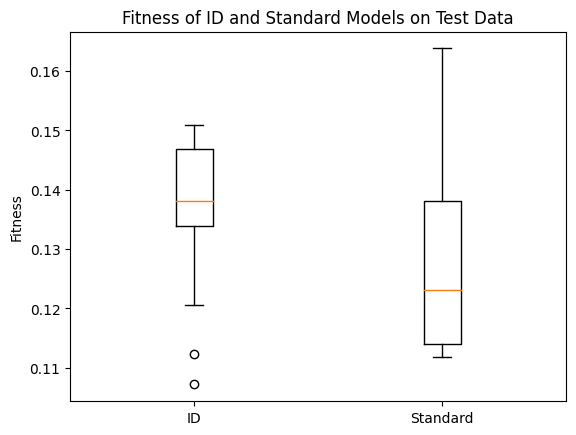

In [46]:
#Box-whisker plot of fitnesses
import matplotlib.pyplot as plt
plt.boxplot([idfits,standardFits])
plt.xticks([1,2],['ID','Standard'])
plt.ylabel('Fitness')
plt.title('Fitness of ID and Standard Models on Test Data')
plt.show()


In [2]:
def debugExperiment(file,targetID,IDrange,name):
    #Import data file
    data=pd.read_csv(file)#"/Users/nathanhaut/Downloads/pmlb/datasets/195_auto_price/195_auto_price.csv")
    
    #Extract data from file
    #vars=data.columns


    #Split train and test data
    trainSize=np.floor(len(data)*0.7)
    testSize=len(data)-trainSize

    trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
    testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

    trainData=data.iloc[trainIndices]
    testData=data.iloc[testIndices]

    #Extract input and response data
    trainInput=np.array(trainData.T)[:-1]
    trainResponse=np.array(trainData.T)[-1]
    testInput=np.array(testData.T)[:-1]
    testResponse=np.array(testData.T)[-1]


    #Get position of max, min, and mean values of response
    maxPos=np.argmax(trainResponse)
    minPos=np.argmin(trainResponse)
    diff=np.abs(trainResponse-np.mean(trainResponse))
    meanPos=np.argmin(diff)
    

    #Create target basis set function
    #func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
    #Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
    #ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10)
    #ID3Omodels=[mods for mods in ID3Omodels if mods[2][2]<1]
    #print("ID3O models done", ID3Omodels[0][2])
    #IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10)
    #IDmodels=[mods for mods in IDmodels if mods[2][1]<1]
    #print("ID models done", IDmodels[0][2])

    compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300)
    print("Complexity models done")
    tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=100,align=False,elitismRate=10,popSize=300)
    print("Tourney models done")

    #Select target models from approaches
    #IDmodel=IDmodels[0]
    #ID3Omodel=ID3Omodels[0]
    compModel=compModels[0]
    tourneyModel=tourneyModels[0]

    #Train Stats
    #IDStats=IDmodels[0][2]
    #ID3OStats=ID3Omodels[0][2]
    compStats=compModels[0][2]
    tourneyStats=tourneyModels[0][2]

    #Align models
    #IDmodel=alignGPModel(IDmodel,trainInput,trainResponse)
    #ID3Omodel=alignGPModel(ID3Omodel,trainInput,trainResponse)
    compModel2=alignGPModel(compModel,trainInput,trainResponse)
    tourneyModel2=alignGPModel(tourneyModel,trainInput,trainResponse)

    #Evaluate models on test data
    #IDfitness=fitness(IDmodel,testInput,testResponse)
    #ID3Ofitness=fitness(ID3Omodel,testInput,testResponse)
    compFitness=fitness(compModel,testInput,testResponse)
    tourneyFitness=fitness(tourneyModel,testInput,testResponse)
    compFitness2=fitness(compModel2,testInput,testResponse)
    tourneyFitness2=fitness(tourneyModel2,testInput,testResponse)

    #IDRMSE=np.linalg.norm(evaluateGPModel(IDmodel,testInput)-testResponse)
    #ID3ORMSE=np.linalg.norm(evaluateGPModel(ID3Omodel,testInput)-testResponse)
    compRMSE=np.linalg.norm(evaluateGPModel(compModel,testInput)-testResponse)
    tourneyRMSE=np.linalg.norm(evaluateGPModel(tourneyModel,testInput)-testResponse)

    #Save results
    results=pd.DataFrame({#'ID':[IDStats, printGPModel(IDmodel),IDfitness,IDRMSE],
                          #'ID3O':[ID3OStats, printGPModel(ID3Omodel),ID3Ofitness,ID3ORMSE],
                          'Complexity':[compStats,compModel,compModel2, printGPModel(compModel),printGPModel(compModel2),compFitness,compFitness2,compRMSE],
                          'Tourney':[tourneyStats,tourneyModel,tourneyModel2, printGPModel(tourneyModel),printGPModel(tourneyModel2),tourneyFitness,tourneyFitness2,tourneyRMSE]})
    results.to_csv('Results/Debug'+name+'.csv')


    #Return target models and fitnesses on test data
    return results


In [11]:
out=debugExperiment('/Users/nathanhaut/Downloads/pmlb/datasets/195_auto_price/195_auto_price.csv',2,1,'autoPrice1')

Complexity models done
Tourney models done


In [12]:
out

,Complexity,Tourney
0,"[0.1479654498151589, 16]",[0.14796263684266253]
1,"[[<function sub at 0x3011a9af0>, <function sqr...","[[pop, <function mult at 0x3011a9b80>, pop, <f..."
2,"[[<function sub at 0x3011a9af0>, <function sqr...","[[pop, <function mult at 0x3011a9b80>, pop, <f..."
3,x6**2*(-x4 + x9)**4/sqrt(sqrt(x13)/sqrt(x11)),799964.285399544*(0.254492158398172*x1 + sqrt(...
4,5.523e-11*x6**2*(-x4 + x9)**4/sqrt(sqrt(x13)/s...,3263.01326017905
5,0.083472,0.079953
6,0.083472,NaN
7,1180085996617218.5,90529929154558303404032.0


In [29]:
out['Tourney'][1]

[array(['pop', <function mult at 0x3011a9b80>, 'pop',
        <function sqrt at 0x3011a9d30>, <function mult at 0x3011a9b80>,
        'pop', <function add at 0x3011a9a60>, 'pop',
        <function add at 0x3011a9a60>, 'pop', 'pop',
        <function sub at 0x3011a9af0>, 'pop', 'pop', 'pop',
        <function sqrd at 0x3011a9dc0>,
        <function protectDiv at 0x1079fc160>,
        <function add at 0x3011a9a60>, <function sqrd at 0x3011a9dc0>,
        'pop', <function add at 0x3011a9a60>,
        <function add at 0x3011a9a60>, <function sqrd at 0x3011a9dc0>,
        <function mult at 0x3011a9b80>, <function sqrd at 0x3011a9dc0>],
       dtype=object),
 [3.9293941561665973,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  <function StackGP.variableSelect.<locals>.<lambda>(

In [18]:
out['Tourney'][2]

[array(['pop', <function mult at 0x3011a9b80>, 'pop',
        <function sqrt at 0x3011a9d30>, <function mult at 0x3011a9b80>,
        'pop', <function add at 0x3011a9a60>, 'pop',
        <function add at 0x3011a9a60>, 'pop', 'pop',
        <function sub at 0x3011a9af0>, 'pop', 'pop', 'pop',
        <function sqrd at 0x3011a9dc0>,
        <function protectDiv at 0x1079fc160>,
        <function add at 0x3011a9a60>, <function sqrd at 0x3011a9dc0>,
        'pop', <function add at 0x3011a9a60>,
        <function add at 0x3011a9a60>, <function sqrd at 0x3011a9dc0>,
        <function mult at 0x3011a9b80>, <function sqrd at 0x3011a9dc0>,
        <function mult at 0x3011a9b80>, <function add at 0x3011a9a60>],
       dtype=object),
 [3.9293941561665973,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  <function StackGP.variableSelect.<locals>.<lam

In [32]:
len(out['Tourney'][2][1])

13

In [33]:
test=copy.deepcopy(out['Tourney'][1])

In [38]:
def alignGPModel(model, data, response): #Aligns a model
    prediction=evaluateGPModel(model,data)
    if (not all(np.isfinite(np.array(prediction)))) or np.all(prediction==prediction[0]):
        return model
    if np.isnan(np.array(prediction)).any() or np.isnan(np.array(response)).any() or not np.isfinite(np.array(prediction,dtype=np.float32)).all():
        return model
    try:
        align=np.polyfit(prediction,response,1,rcond=1e-16)#np.round(np.polyfit(prediction,response,1,rcond=1e-16),decimals=14)
    except np.linalg.LinAlgError:
        #print("Alignment failed for: ", model, " with prediction: ", prediction, "and reference data: ", response)
        return model
    newModel=trimModel(model)
    newModel[0]=np.array(newModel[0].tolist()+[mult,add],dtype=object)
    newModel[1]=newModel[1]+align.tolist()
    setModelQuality(newModel,data,response)
    return newModel

In [37]:
np.polyfit(evaluateGPModel(test,trainInput),trainResponse,1,rcond=1e-16)

array([7.56750620e-19, 3.19191035e+03])

In [39]:
alignGPModel(trimModel(out['Tourney'][1]),trainInput,trainResponse)

[array(['pop', <function mult at 0x3011a9b80>, 'pop',
        <function sqrt at 0x3011a9d30>, <function mult at 0x3011a9b80>,
        'pop', <function add at 0x3011a9a60>, 'pop',
        <function add at 0x3011a9a60>, 'pop', 'pop',
        <function sub at 0x3011a9af0>, 'pop', 'pop', 'pop',
        <function sqrd at 0x3011a9dc0>,
        <function protectDiv at 0x1079fc160>,
        <function add at 0x3011a9a60>, <function sqrd at 0x3011a9dc0>,
        'pop', <function add at 0x3011a9a60>,
        <function add at 0x3011a9a60>, <function sqrd at 0x3011a9dc0>,
        <function mult at 0x3011a9b80>, <function sqrd at 0x3011a9dc0>,
        <function mult at 0x3011a9b80>, <function add at 0x3011a9a60>],
       dtype=object),
 [3.9293941561665973,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  <function StackGP.variableSelect.<locals>.<lambda>(variables)>,
  <function StackGP.variableSelect.<locals>.<lam

In [26]:
def trimModel2(mod): #Removes extra pop operators that do nothing
    model=copy.deepcopy(mod)
    i=0
    varStack=len(mod[1])
    tempStack=0
    varStack-=getArity(model[0][i])
    tempStack+=1
    i+=1
    while varStack>0:
        if model[0][i]=='pop':
            varStack-=1
            tempStack+=1
        else:
            
            take=getArity(model[0][i])-tempStack
            if take>0:
                varStack-=take
                tempStack=1
            else:
                tempStack-=getArity(model[0][i])-1
        i+=1
    model[0]=np.array(model[0][:i].tolist()+[j for j in model[0][i:] if not j=='pop'],dtype=object)
    return model

In [ ]:
def trimModel2(mod): #Removes extra pop operators that do nothing
    model=copy.deepcopy(mod)
    i=0
    varStack=len(mod[1])
    tempStack=0
    varStack-=getArity(model[0][i])
    tempStack+=1
    i+=1
    while varStack>0:
        if model[0][i]=='pop':
            varStack-=1
            tempStack+=1
        else:
            
            take=getArity(model[0][i])-tempStack
            if take>0:
                varStack-=take
                tempStack=1
            else:
                tempStack-=getArity(model[0][i])-1
        i+=1
    model[0]=np.array(model[0][:i].tolist()+[j for j in model[0][i:] if not j=='pop'],dtype=object)
    return model

In [2]:
data=pd.read_csv('/Users/nathanhaut/Downloads/pmlb/datasets/225_puma8NH/225_puma8NH.csv')

In [3]:
targetID=6.5
IDrange=1    
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10)
temp=[mods for mods in ID3Omodels if mods[2][2]<1]
if len(temp)>0:
    ID3Omodels=temp
print("ID3O models done", ID3Omodels[0][2])
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10)
temp=[mods for mods in IDmodels if mods[2][1]<1]
if len(temp)>0:
    IDmodels=temp
print("ID models done", IDmodels[0][2])

compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=100,align=False,elitismRate=10,popSize=300)
print("Tourney models done")

ID3O models done [0.4084378539038548, 16, 4.5]
ID models done [0.43558784184476373, 3.833333333333333]
Complexity models done
Tourney models done


In [4]:
IDmodels[0]

[array(['pop', <function add at 0x138ea8a60>, 'pop',
        <function add at 0x138ea8a60>, <function add at 0x138ea8a60>,
        'pop', 'pop', 'pop', <function sqrd at 0x138ea8dc0>, 'pop', 'pop',
        <function add at 0x138ea8a60>, <function inv at 0x138ea8e50>,
        <function mult at 0x138ea8b80>, <function sqrd at 0x138ea8dc0>,
        <function sqrd at 0x138ea8dc0>, <function sqrd at 0x138ea8dc0>,
        <function sqrd at 0x138ea8dc0>, <function sqrd at 0x138ea8dc0>,
        <function sqrd at 0x138ea8dc0>, <function sqrd at 0x138ea8dc0>,
        <function sqrd at 0x138ea8dc0>, <function sqrd at 0x138ea8dc0>,
        <function sqrd at 0x138ea8dc0>, <function sqrd at 0x138ea8dc0>,
        <function sqrd at 0x138ea8dc0>, <function inv at 0x138ea8e50>,
        <function exp at 0x138ea8c10>, <function exp at 0x138ea8c10>,
        <function inv at 0x138ea8e50>, <function add at 0x138ea8a60>,
        <function add at 0x138ea8a60>, <function inv at 0x138ea8e50>,
        <function m

In [8]:
IDComplexities=[stackGPModelComplexity(mod) for mod in IDmodels]
ID3Complexities=[stackGPModelComplexity(mod) for mod in ID3Omodels]
compComplexities=[stackGPModelComplexity(mod) for mod in compModels]
tourneyComplexities=[stackGPModelComplexity(mod) for mod in tourneyModels]

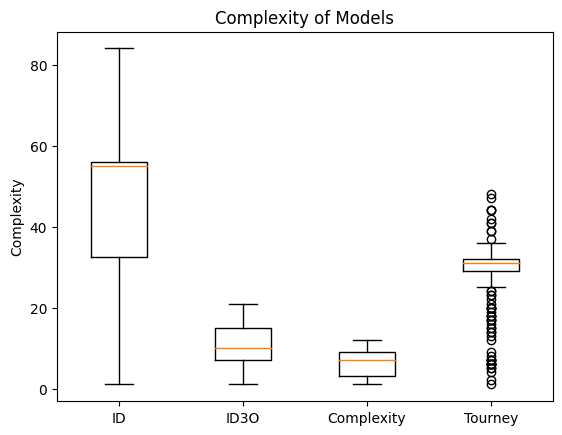

In [9]:
#Box-whisker plot of complexities
import matplotlib.pyplot as plt
plt.boxplot([IDComplexities,ID3Complexities,compComplexities,tourneyComplexities])
plt.xticks([1,2,3,4],['ID','ID3O','Complexity','Tourney'])
plt.ylabel('Complexity')
plt.title('Complexity of Models')
plt.show()

In [14]:
IDFitnesses=[fitness(mod,testInput,testResponse) for mod in IDmodels]
ID3Fitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Omodels]
compFitnesses=[fitness(mod,testInput,testResponse) for mod in compModels]
tourneyFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyModels]
ID3Fitnesses=[fit for fit in ID3Fitnesses if not np.isnan(fit)]

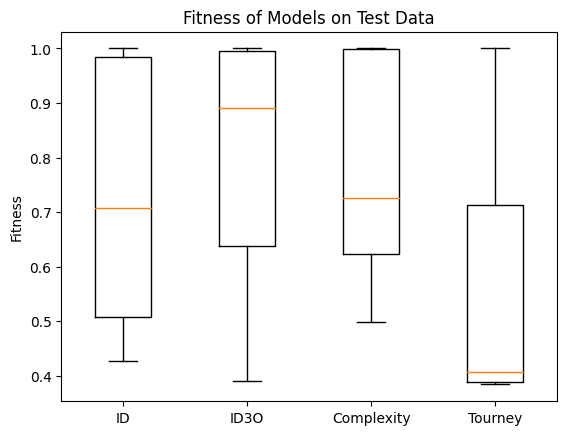

In [15]:
#Box-whisker plot of fitnesses
import matplotlib.pyplot as plt
plt.boxplot([IDFitnesses,ID3Fitnesses,compFitnesses,tourneyFitnesses])
plt.xticks([1,2,3,4],['ID','ID3O','Complexity','Tourney'])
plt.ylabel('Fitness')
plt.title('Fitness of Models on Test Data')
plt.show()

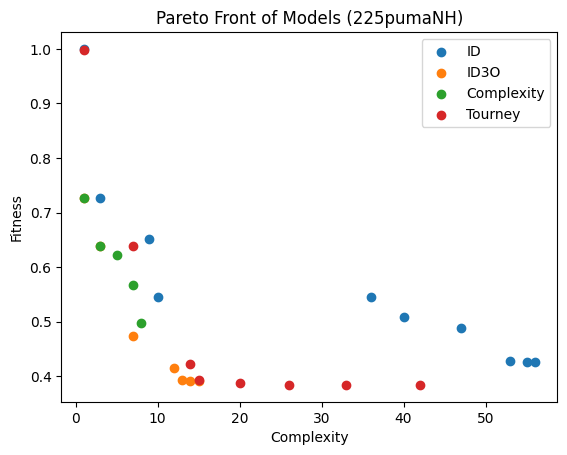

In [19]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]

IDFront=paretoTournament(IDmodels)
ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models (225pumaNH)')
plt.legend()

plt.show()

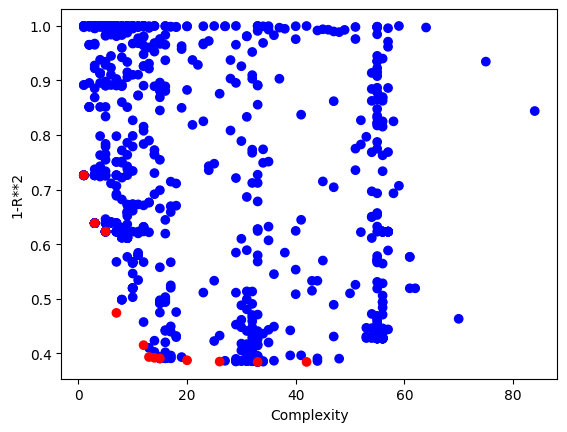

In [22]:
allModels=IDmodels+ID3Omodels+compModels+tourneyModels
plotModels(allModels)

In [26]:
values=[mod[-1]+[func(mod)] for mod in allModels]

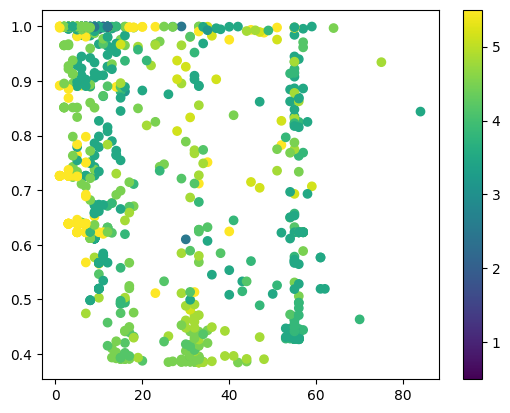

In [33]:
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter)


In [35]:
ID3OmodelsVals=[func(mod) for mod in ID3Omodels]

1.5

## 195 Auto Price

In [37]:
data=pd.read_csv('/Users/nathanhaut/Downloads/pmlb/datasets/195_auto_price/195_auto_price.csv')

In [39]:
targetID=2.18
IDrange=.927    
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10)
temp=[mods for mods in ID3Omodels if mods[2][2]<1]
if len(temp)>0:
    ID3Omodels=temp
print("ID3O models done", ID3Omodels[0][2])
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10)
temp=[mods for mods in IDmodels if mods[2][1]<1]
if len(temp)>0:
    IDmodels=temp
print("ID models done", IDmodels[0][2])

compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=100,align=False,elitismRate=10,popSize=300)
print("Tourney models done")

ID3O models done [0.13224747321035957, 13, 0.8929999999999996]
ID models done [0.1727737539059242, 0.0]
Complexity models done
Tourney models done


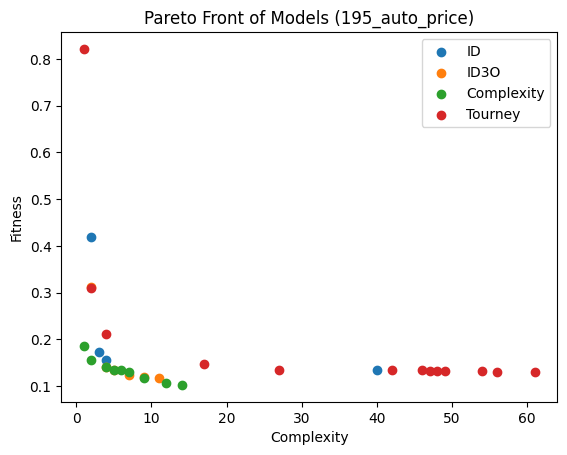

In [40]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]

IDFront=paretoTournament(IDmodels)
ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models (195_auto_price)')
plt.legend()

plt.show()

In [44]:
import dill
dill.dump([IDmodels,ID3Omodels,compModels,tourneyModels],open('Models/195_auto_price.p','wb'))

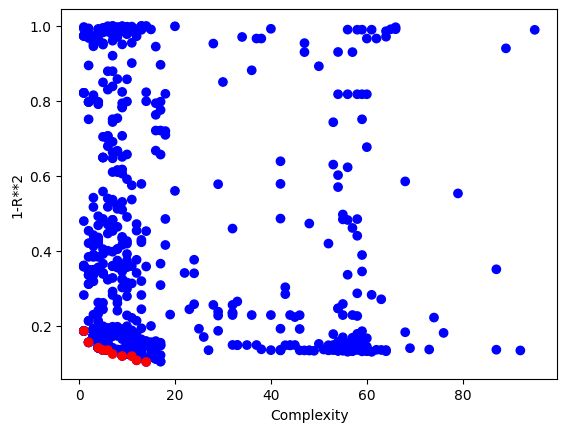

In [41]:
allModels=IDmodels+ID3Omodels+compModels+tourneyModels
plotModels(allModels)

Text(0, 0.5, 'Fitness (1-R^2)')

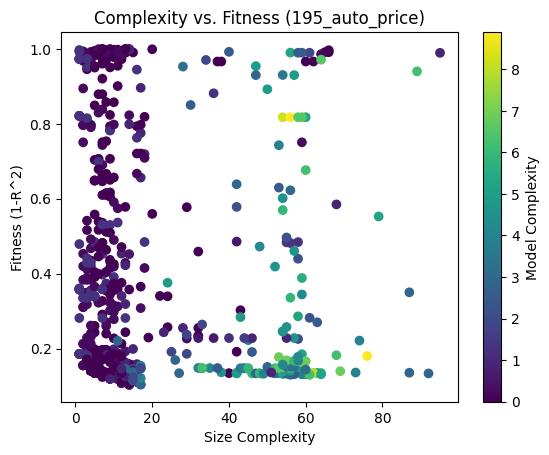

In [45]:
values=[mod[-1]+[func(mod)] for mod in allModels]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness (195_auto_price)')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

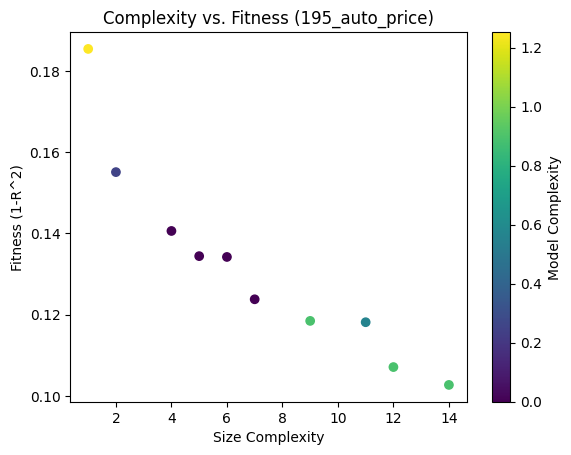

In [46]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness (195_auto_price)')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

## 641 fri c1 500 10

In [47]:
data=pd.read_csv('/Users/nathanhaut/Downloads/pmlb/datasets/641_fri_c1_500_10/641_fri_c1_500_10.csv')

In [68]:
targetID=7.77
IDrange=1.121    
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
#temp=[mods for mods in ID3Omodels if mods[2][2]<1]
#if len(temp)>0:
#    ID3Omodels=temp
print("ID3O models done", ID3Omodels[0][2])
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
#temp=[mods for mods in IDmodels if mods[2][1]<1]
#if len(temp)>0:
#    IDmodels=temp
print("ID models done", IDmodels[0][2])

compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=100,align=False,elitismRate=10,popSize=300,maxComplexity=300)

ID3O models done [0.7281952086558907, 12, 3.6489999999999996]
ID models done [0.5335543529257782, 4.648999999999999]
Complexity models done


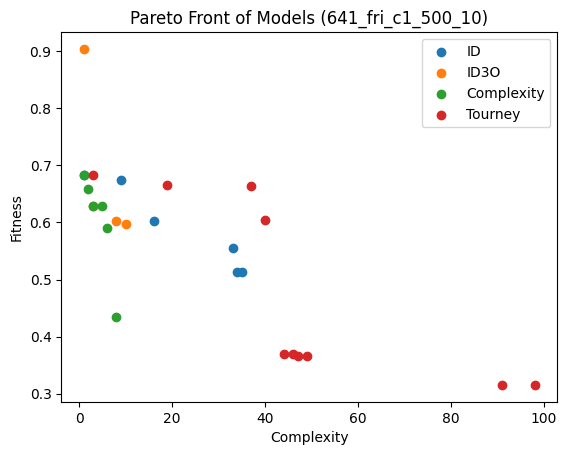

In [69]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]

IDFront=paretoTournament(IDmodels)
ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models (641_fri_c1_500_10)')
plt.legend()

plt.show()

In [70]:
import dill
dill.dump([IDmodels,ID3Omodels,compModels,tourneyModels],open('Models/641_fri_c1_500_10.p','wb'))

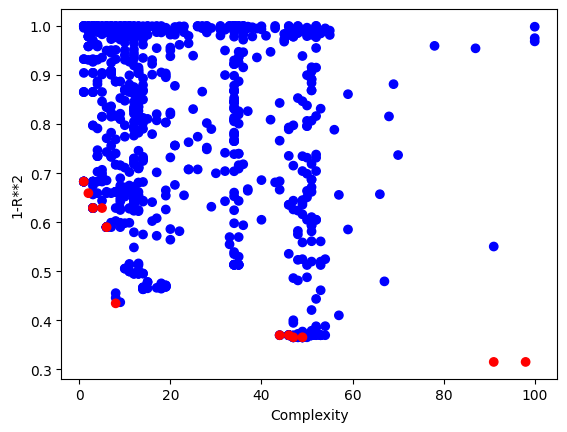

In [71]:
allModels=IDmodels+ID3Omodels+compModels+tourneyModels
plotModels(allModels)

Text(0, 0.5, 'Fitness (1-R^2)')

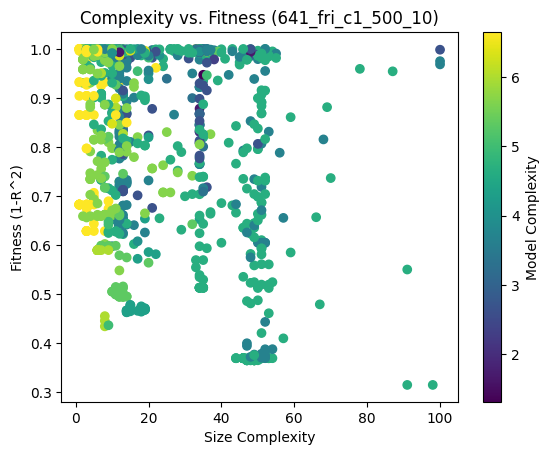

In [72]:
values=[mod[-1]+[func(mod)] for mod in allModels]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness (641_fri_c1_500_10)')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

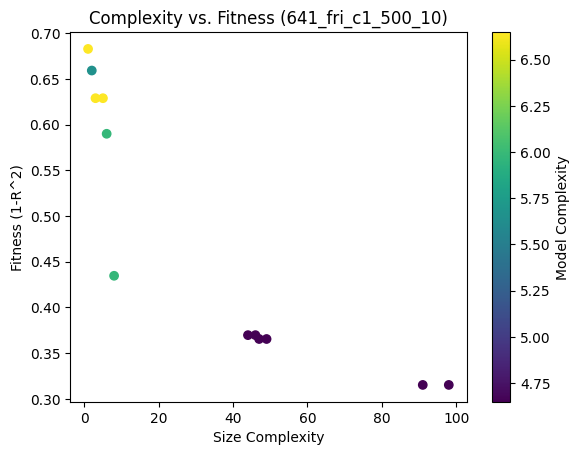

In [73]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness (641_fri_c1_500_10)')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

## 654_fri_c0_500_10

In [74]:
data=pd.read_csv('/Users/nathanhaut/Downloads/pmlb/datasets/654_fri_c0_500_10/654_fri_c0_500_10.csv')

In [75]:
targetID=8.04
IDrange=1.93    
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in ID3Omodels if mods[2][2]<1]
if len(temp)>0:
    ID3Omodels=temp
print("ID3O models done", ID3Omodels[0][2])
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in IDmodels if mods[2][1]<1]
if len(temp)>0:
    IDmodels=temp
print("ID models done", IDmodels[0][2])

compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=100,align=False,elitismRate=10,popSize=300,maxComplexity=300)

ID3O models done [0.32176835518638236, 20, 5.109999999999999]
ID models done [0.17365257204457885, 0.4433333333333327]
Complexity models done


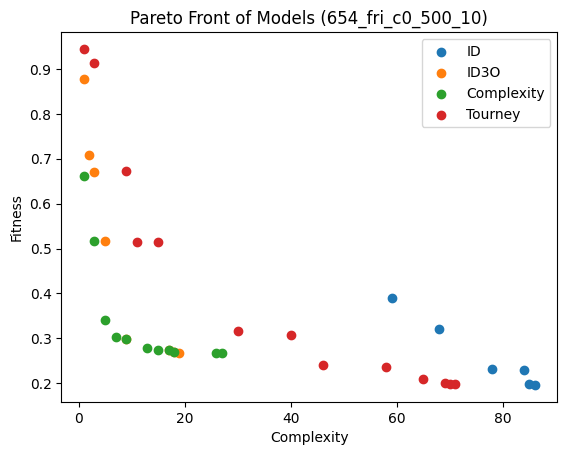

In [76]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]

IDFront=paretoTournament(IDmodels)
ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models (654_fri_c0_500_10)')
plt.legend()

plt.show()

In [77]:
import dill
dill.dump([IDmodels,ID3Omodels,compModels,tourneyModels],open('Models/654_fri_c0_500_10.p','wb'))

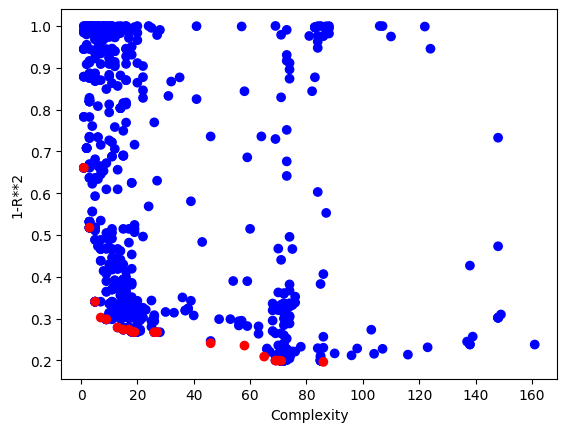

In [78]:
allModels=IDmodels+ID3Omodels+compModels+tourneyModels
plotModels(allModels)

Text(0, 0.5, 'Fitness (1-R^2)')

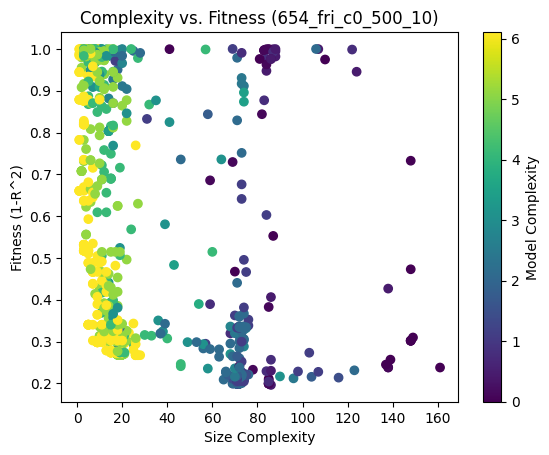

In [79]:
values=[mod[-1]+[func(mod)] for mod in allModels]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness (654_fri_c0_500_10)')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

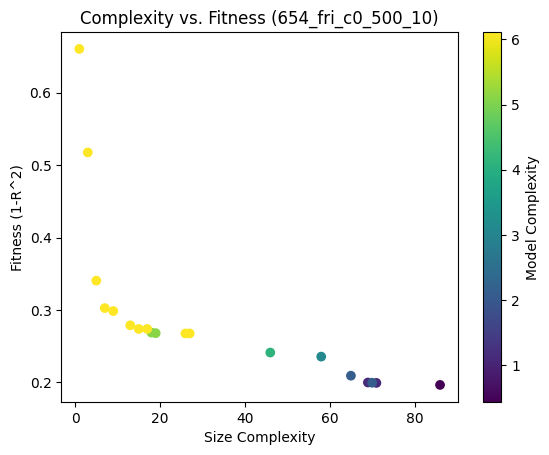

In [80]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness (654_fri_c0_500_10)')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

## 1027_ESL

In [83]:
name="1027_ESL"
data=pd.read_csv('/Users/nathanhaut/Downloads/pmlb/datasets/'+name+'/'+name+'.csv')

In [96]:
targetID=3.53
IDrange=1.13    
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament

compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=200,align=False,elitismRate=0,popSize=500,maxComplexity=300)

Complexity models done


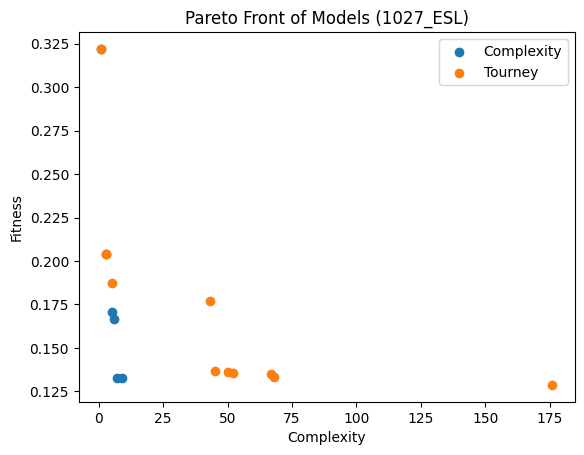

In [102]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]

compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models ('+name+')')
plt.legend()

plt.show()
import dill
dill.dump([compModels,tourneyModels],open('Models/'+name+'.p','wb'))
allModels=compModels+tourneyModels

KeyboardInterrupt: 

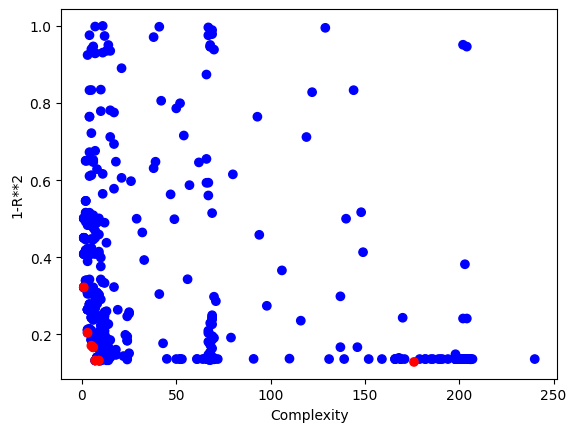

In [98]:

plotModels(allModels)

Text(0, 0.5, 'Fitness (1-R^2)')

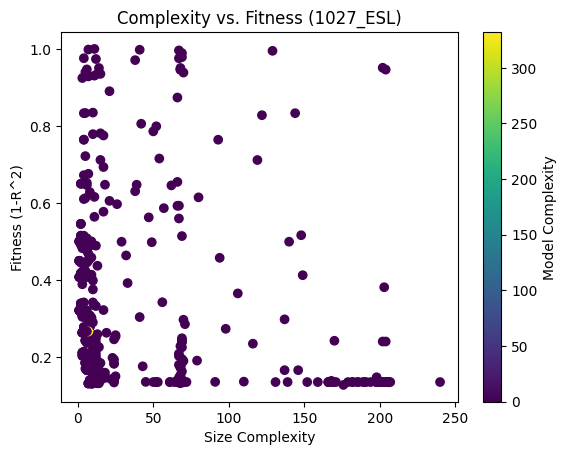

In [104]:
values=[mod[-1]+[func(mod)] for mod in allModels]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

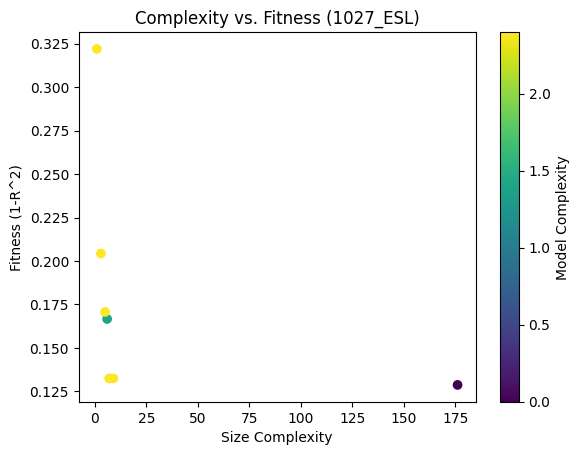

In [103]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

## 1028_SWD

In [105]:
name="1028_SWD"
data=pd.read_csv('/Users/nathanhaut/Downloads/pmlb/datasets/'+name+'/'+name+'.csv')

In [106]:
targetID=6.79
IDrange=2.63    
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament

compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)

Complexity models done


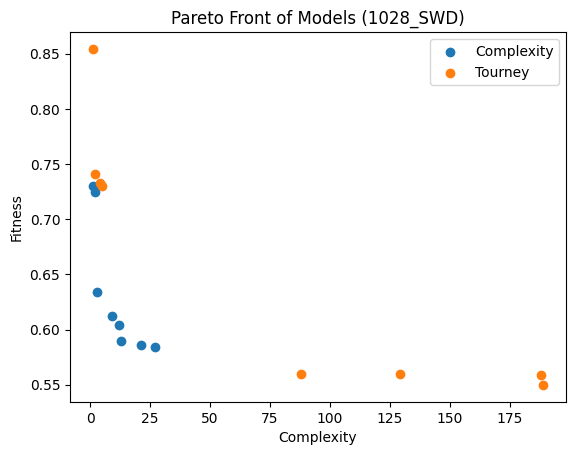

In [107]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]

compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models ('+name+')')
plt.legend()

plt.show()
import dill
dill.dump([compModels,tourneyModels],open('Models/'+name+'.p','wb'))
allModels=compModels+tourneyModels

Text(0, 0.5, 'Fitness (1-R^2)')

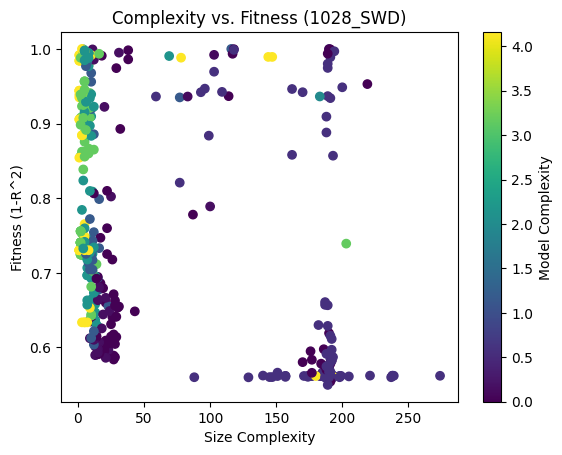

In [108]:
values=[mod[-1]+[func(mod)] for mod in allModels]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

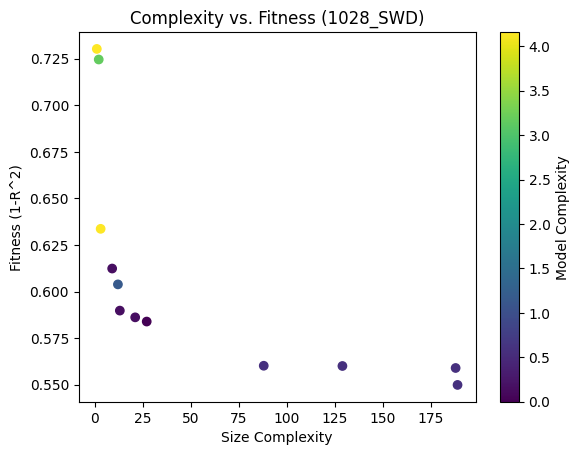

In [109]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

## 1089_USCrime

In [110]:
name="1089_USCrime"
data=pd.read_csv('/Users/nathanhaut/Downloads/pmlb/datasets/'+name+'/'+name+'.csv')

In [115]:
targetID=3.58
IDrange=2.2    
totalDim=len(data.columns)-1
maxDim=totalDim-(IDrange+targetID)
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in ID3Omodels if mods[2][2]<1]
if len(temp)>0:
    ID3Omodels=temp
print("ID3O models done", ID3Omodels[0][2])
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in IDmodels if mods[2][1]<1]
if len(temp)>0:
    IDmodels=temp
print("ID models done", IDmodels[0][2])
compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)

ID3O models done [0.09731729766238306, 16, 0.0]
ID models done [0.046964659599010194, 0.0]
Complexity models done


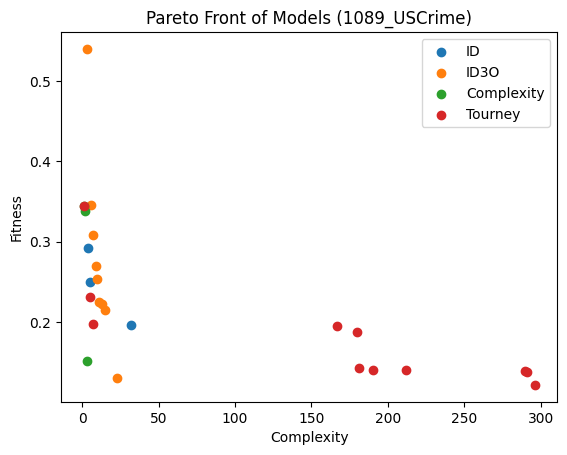

In [136]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]
IDmodels=removeIndeterminateModels(IDmodels)
IDFront=paretoTournament(IDmodels)
ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models ('+name+')')
plt.legend()

plt.show()
import dill
dill.dump([ID3Omodels,IDmodels,compModels,tourneyModels],open('Models/'+name+'.p','wb'))
allModels=ID3Omodels+IDmodels+compModels+tourneyModels

In [125]:
func(paretoTournament(allModels)[-1])

663.2199999999999

Text(0, 0.5, 'Fitness (1-R^2)')

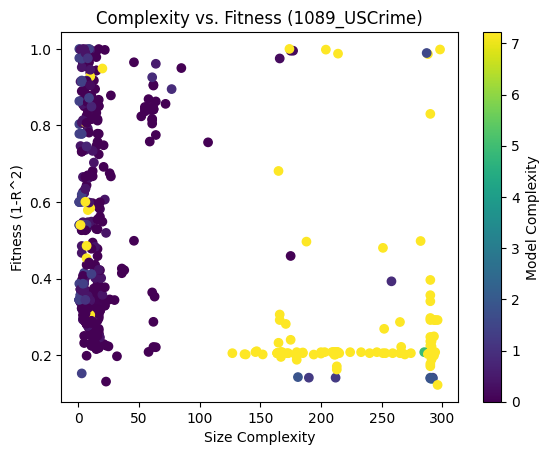

In [129]:
values=[mod[-1]+[func(mod)] for mod in allModels]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

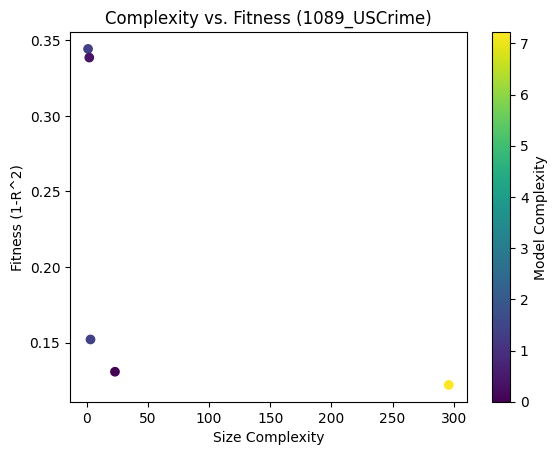

In [130]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

In [131]:
modelComplexities=[stackGPModelComplexity(mod) for mod in ID3Omodels]
modelComplexities

[16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 16,
 16,
 16,
 15,
 15,
 15,
 15,
 15,
 16,
 13,
 13,
 13,
 13,
 15,
 16,
 18,
 15,
 17,
 18,
 17,
 13,
 21,
 13,
 15,
 15,
 16,
 15,
 13,
 15,
 17,
 13,
 15,
 15,
 16,
 25,
 16,
 17,
 16,
 13,
 17,
 17,
 13,
 13,
 19,
 16,
 16,
 13,
 17,
 13,
 11,
 11,
 16,
 23,
 15,
 13,
 14,
 17,
 17,
 17,
 17,
 17,
 14,
 17,
 13,
 15,
 15,
 14,
 12,
 16,
 17,
 16,
 18,
 14,
 15,
 12,
 14,
 9,
 16,
 10,
 16,
 11,
 14,
 11,
 7,
 10,
 10,
 11,
 13,
 13,
 22,
 18,
 16,
 17,
 17,
 17,
 11,
 12,
 16,
 16,
 19,
 15,
 15,
 6,
 17,
 17,
 18,
 16,
 16,
 8,
 8,
 18,
 14,
 18,
 12,
 10,
 7,
 7,
 17,
 17,
 23,
 16,
 16,
 12,
 13,
 22,
 7,
 3,
 4,
 4,
 5,
 10,
 8,
 15,
 4,
 8,
 11,
 16,
 5,
 14,
 6,
 18,
 17,
 10,
 16,
 6,
 17,
 12,
 11,
 8,
 17,
 16,
 17,
 11,
 14,
 16,
 13,
 14,
 17,
 4,
 14,
 17,
 3,
 11,
 13,
 4,
 4,
 14,
 14,
 13,
 10,
 15,
 15,
 5,
 6,
 15,
 5,
 9]

## 227_cpu_small

In [137]:
name="227_cpu_small"
data=pd.read_csv('/Users/nathanhaut/Downloads/pmlb/datasets/'+name+'/'+name+'.csv')

In [138]:
targetID=2.56
IDrange=0.70    
totalDim=len(data.columns)-1
maxDim=totalDim-(IDrange+targetID)
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in ID3Omodels if mods[2][2]<1]
if len(temp)>0:
    ID3Omodels=temp
print("ID3O models done", ID3Omodels[0][2])
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in IDmodels if mods[2][1]<1]
if len(temp)>0:
    IDmodels=temp
print("ID models done", IDmodels[0][2])
compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)

ID3O models done [0.06752395463165817, 13, 0.5266666666666668]
ID models done [0.06443321321564088, 0.15333333333333343]
Complexity models done


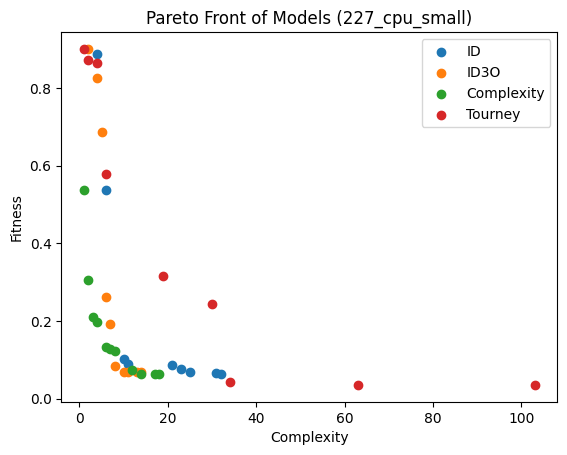

In [139]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]
IDmodels=removeIndeterminateModels(IDmodels)
IDFront=paretoTournament(IDmodels)
ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models ('+name+')')
plt.legend()

plt.show()
import dill
dill.dump([ID3Omodels,IDmodels,compModels,tourneyModels],open('Models/'+name+'.p','wb'))
allModels=ID3Omodels+IDmodels+compModels+tourneyModels

Text(0, 0.5, 'Fitness (1-R^2)')

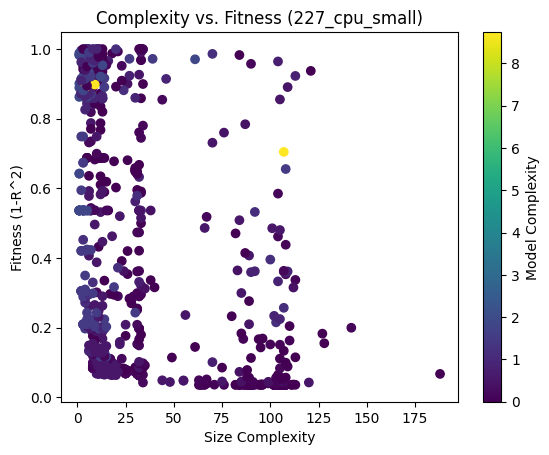

In [140]:
values=[mod[-1]+[func(mod)] for mod in allModels]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

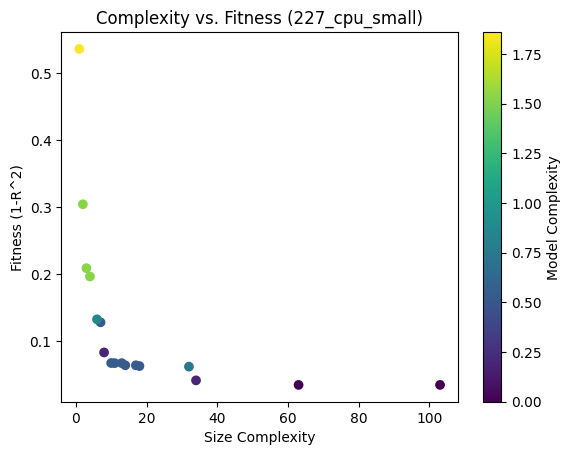

In [143]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

In [144]:
tourneyModelsL=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=1000,align=False,elitismRate=0,popSize=300,maxComplexity=500)

Text(0, 0.5, 'Fitness (1-R^2)')

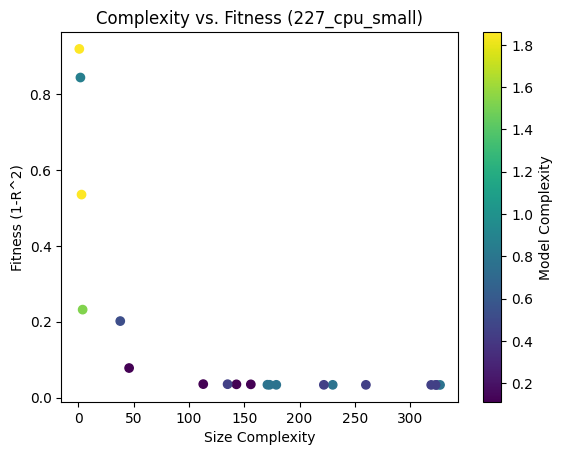

In [145]:
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModelsL]
values=[mod[-1]+[func(mod)] for mod in paretoTournament(tourneyModelsL)]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

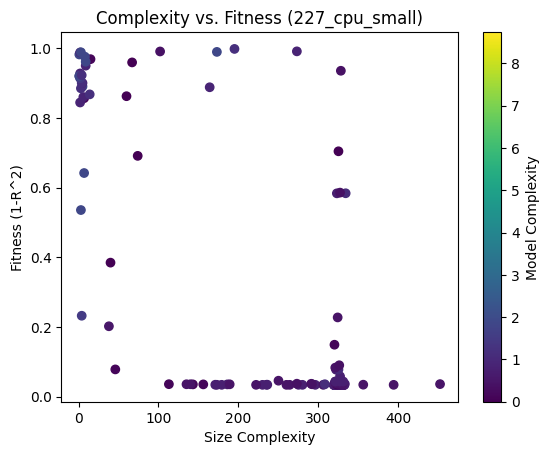

In [146]:
values=[mod[-1]+[func(mod)] for mod in tourneyModelsL]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

## 227_cpu_small (10% Train)

In [147]:
name="227_cpu_small"
data=pd.read_csv('/Users/nathanhaut/Downloads/pmlb/datasets/'+name+'/'+name+'.csv')

In [148]:
targetID=2.56
IDrange=0.70    
totalDim=len(data.columns)-1
maxDim=totalDim-(IDrange+targetID)
trainSize=np.floor(len(data)*0.1)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in ID3Omodels if mods[2][2]<1]
if len(temp)>0:
    ID3Omodels=temp
print("ID3O models done", ID3Omodels[0][2])
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in IDmodels if mods[2][1]<1]
if len(temp)>0:
    IDmodels=temp
print("ID models done", IDmodels[0][2])
compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)

ID3O models done [0.04615882894325374, 17, 0.7400000000000002]
ID models done [0.0387953513472975, 0.15333333333333343]
Complexity models done


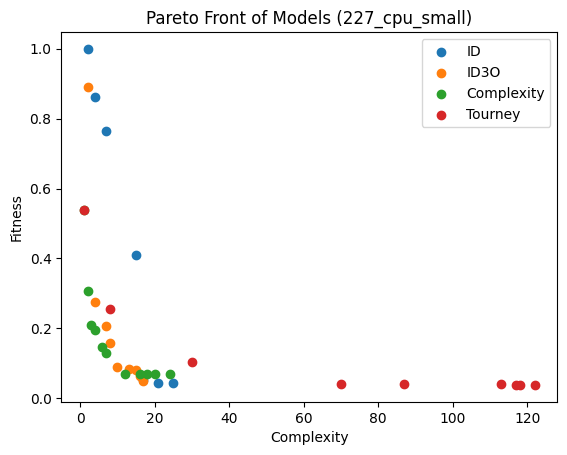

In [149]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]
IDmodels=removeIndeterminateModels(IDmodels)
IDFront=paretoTournament(IDmodels)
ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models ('+name+')')
plt.legend()

plt.show()
import dill
dill.dump([ID3Omodels,IDmodels,compModels,tourneyModels],open('Models/'+name+'T10.p','wb'))
allModels=ID3Omodels+IDmodels+compModels+tourneyModels

Text(0, 0.5, 'Fitness (1-R^2)')

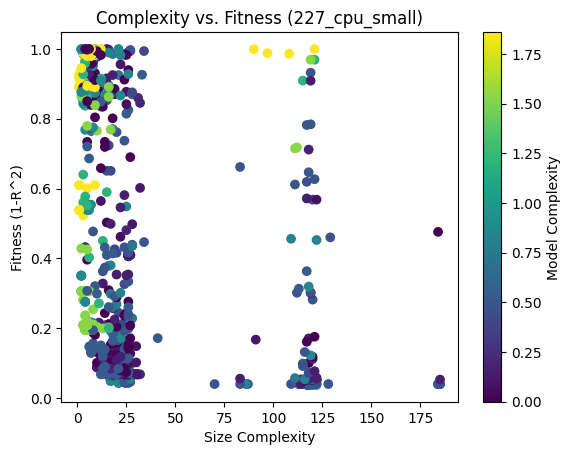

In [150]:
values=[mod[-1]+[func(mod)] for mod in allModels]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

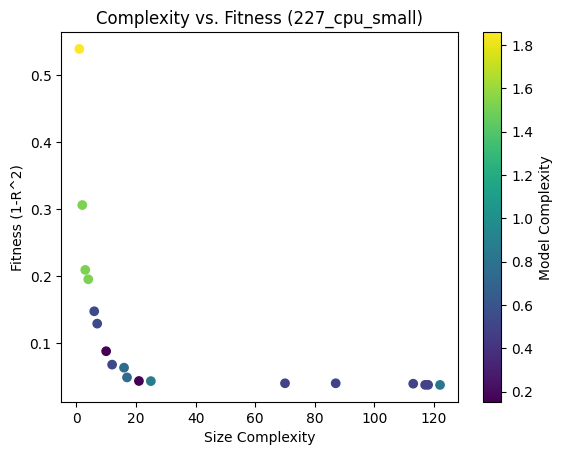

In [151]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')